In [1]:
import numpy as np
import pandas as pd
import os
import chardet
!pip install category_encoders
import pandas as pd
from category_encoders import TargetEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import joblib

# 1. Data Exploration

In [2]:
# First detect the encoding
file_path = '/kaggle/input/unsw-nb15/UNSW_NB15_training-set.csv'

# Read a sample to detect encoding
with open(file_path, 'rb') as f:
    raw_data = f.read(10000)  # Read first 10KB to detect encoding
    result = chardet.detect(raw_data)

print(f"Detected encoding: {result['encoding']} with confidence: {result['confidence']}")

# Load with detected encoding
df = pd.read_csv(file_path, encoding=result['encoding'])

# Set option to display all columns
pd.set_option('display.max_columns', None)

display(df.head())

Detected encoding: UTF-8-SIG with confidence: 1.0


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,254,0,180363632.0,0.0,0,0,0.011,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,248,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,254,0,881000000.0,0.0,0,0,0.008,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,881,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,254,0,854400000.0,0.0,0,0,0.005,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,534,0,0,0,3,2,1,1,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,254,0,600000000.0,0.0,0,0,0.006,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,450,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,254,0,850400000.0,0.0,0,0,0.010,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,1063,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0


In [3]:
df.shape

(82332, 45)

In [4]:
# Define the list of input CSV file paths
input_csv_files = [
    '/kaggle/input/unsw-nb15/UNSW-NB15_1.csv',
    '/kaggle/input/unsw-nb15/UNSW-NB15_2.csv',
    '/kaggle/input/unsw-nb15/UNSW-NB15_3.csv',
    '/kaggle/input/unsw-nb15/UNSW-NB15_4.csv'
]

# Define the list of desired attack categories
desired_categories = [
    'Fuzzers',
    'Dos',
    'Reconnaissance',
    'Analysis',
    'Backdoor',
    'Shellcode',
    'Worms'
]

# Load the features file to get column names
file_path_features = '/kaggle/input/unsw-nb15/NUSW-NB15_features.csv'

# Detect encoding for the features file
with open(file_path_features, 'rb') as f:
    raw_data = f.read(10000)  # Read first 10KB to detect encoding
    result = chardet.detect(raw_data)
encoding = result['encoding']

# Load the features CSV into features_df
features_df = pd.read_csv(file_path_features, encoding=encoding)
print(f"Loaded '{os.path.basename(file_path_features)}' using encoding: {encoding}")


new_column_names = features_df['Name'].tolist()

print(input_csv_files)

print(desired_categories)

print(new_column_names)

Loaded 'NUSW-NB15_features.csv' using encoding: Windows-1252
['/kaggle/input/unsw-nb15/UNSW-NB15_1.csv', '/kaggle/input/unsw-nb15/UNSW-NB15_2.csv', '/kaggle/input/unsw-nb15/UNSW-NB15_3.csv', '/kaggle/input/unsw-nb15/UNSW-NB15_4.csv']
['Fuzzers', 'Dos', 'Reconnaissance', 'Analysis', 'Backdoor', 'Shellcode', 'Worms']
['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'service', 'Sload', 'Dload', 'Spkts', 'Dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'Sjit', 'Djit', 'Stime', 'Ltime', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat', 'Label']


In [5]:
# Initialize a list to store paths of filtered CSV files
processed_filtered_files = []

for file_path in input_csv_files:
    print(f"\nProcessing file: {file_path}")

    # Read a sample to detect encoding
    with open(file_path, 'rb') as f:
        raw_data = f.read(10000)  # Read first 10KB to detect encoding
        result = chardet.detect(raw_data)

    encoding = result['encoding']
    print(f"Detected encoding: {encoding} with confidence: {result['confidence']}")

    df_current = pd.read_csv(file_path, encoding=encoding, header=None, low_memory=False)

    print(f"Loaded {os.path.basename(file_path)} with {df_current.shape[0]} rows and {df_current.shape[1]} columns.")

    # Assign the new_column_names to the DataFrame
    if len(new_column_names) == df_current.shape[1]:
        df_current.columns = new_column_names
        print("Assigned new column names successfully.")
    else:
        print(f"Error: Number of columns in {os.path.basename(file_path)} ({df_current.shape[1]}) does not match the number of new_column_names ({len(new_column_names)}). Skipping column assignment for this file.")
        continue # Skip to the next file if column assignment fails

    # Filter the DataFrame for desired attack categories
    if 'attack_cat' in df_current.columns:
        df_filtered = df_current[df_current['attack_cat'].isin(desired_categories)]
        print(f"Filtered data contains {df_filtered.shape[0]} rows for desired categories.")

        # Define output file path
        file_name = os.path.basename(file_path).replace('.csv', '')
        output_file_path = f"/content/filtered_{file_name}.csv"

        # Save the filtered data to a new CSV file
        df_filtered.to_csv(output_file_path, index=False)
        print(f"Filtered data saved to {output_file_path}")

        processed_filtered_files.append(output_file_path)
    else:
        print("Error: 'attack_cat' column not found after loading or column assignment. Cannot filter.")


print("\nAll files processed. Filtered CSV files are:")
for f_path in processed_filtered_files:
    print(f_path)


Processing file: /kaggle/input/unsw-nb15/UNSW-NB15_1.csv
Detected encoding: UTF-8-SIG with confidence: 1.0
Loaded UNSW-NB15_1.csv with 700001 rows and 49 columns.
Assigned new column names successfully.
Filtered data contains 2532 rows for desired categories.
Filtered data saved to /content/filtered_UNSW-NB15_1.csv

Processing file: /kaggle/input/unsw-nb15/UNSW-NB15_2.csv
Detected encoding: ascii with confidence: 1.0
Loaded UNSW-NB15_2.csv with 700001 rows and 49 columns.
Assigned new column names successfully.
Filtered data contains 1018 rows for desired categories.
Filtered data saved to /content/filtered_UNSW-NB15_2.csv

Processing file: /kaggle/input/unsw-nb15/UNSW-NB15_3.csv
Detected encoding: ascii with confidence: 1.0
Loaded UNSW-NB15_3.csv with 700001 rows and 49 columns.
Assigned new column names successfully.
Filtered data contains 1699 rows for desired categories.
Filtered data saved to /content/filtered_UNSW-NB15_3.csv

Processing file: /kaggle/input/unsw-nb15/UNSW-NB15_4.

In [6]:
csv_files_to_combine = [
    '/content/filtered_UNSW-NB15_1.csv',
    '/content/filtered_UNSW-NB15_2.csv',
    '/content/filtered_UNSW-NB15_3.csv',
    '/content/filtered_UNSW-NB15_4.csv'
]

df_list = []

print("Loading individual filtered CSV files...")
for file_path in csv_files_to_combine:
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df_list.append(df)
        print(f"Loaded {os.path.basename(file_path)} with {len(df)} rows.")
    else:
        print(f"Warning: File {file_path} not found.)")

# Concatenate all DataFrames in the list
if df_list:
    combined_df = pd.concat(df_list, ignore_index=True)
    print(f"Successfully combined {len(df_list)} files into a single DataFrame.")

    # Define the output file path for the combined data
    output_combined_file = '/content/combined_filtered_data.csv'

    combined_df.to_csv(output_combined_file, index=False, header=True)
    print(f"Combined data saved to {output_combined_file}")

    display(combined_df.head())
else:
    print("No files were successfully loaded, so no combined file was created.")

Loading individual filtered CSV files...
Loaded filtered_UNSW-NB15_1.csv with 2532 rows.
Loaded filtered_UNSW-NB15_2.csv with 1018 rows.
Loaded filtered_UNSW-NB15_3.csv with 1699 rows.
Loaded filtered_UNSW-NB15_4.csv with 1379 rows.
Successfully combined 4 files into a single DataFrame.
Combined data saved to /content/combined_filtered_data.csv


,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,Sload,Dload,Spkts,Dpkts,swin,dwin,stcpb,dtcpb,smeansz,dmeansz,trans_depth,res_bdy_len,Sjit,Djit,Stime,Ltime,Sintpkt,Dintpkt,tcprtt,synack,ackdat,is_sm_ips_ports,ct_state_ttl,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label
0,175.45.176.0,13284,149.171.126.16,80,tcp,FIN,2.390390,1362,268,254,252,6,1,http,4.233619e+03,749.668518,14,6,255,255,3897219059,2466816006,97,45,1,0,18786.711400,941.724938,1421927414,1421927416,183.579303,474.259406,0.066088,0.017959,0.048129,0,1,1.0,0.0,0,5,2,2,1,1,1,1,Reconnaissance,1
1,175.45.176.3,22359,149.171.126.11,111,udp,INT,0.000017,168,0,254,0,0,0,-,3.952941e+07,0.000000,2,0,0,0,0,0,84,0,0,0,0.000000,0.000000,1421927426,1421927426,0.017000,0.000000,0.000000,0.000000,0.000000,0,2,0.0,0.0,0,2,1,1,1,1,1,1,Reconnaissance,1
2,175.45.176.0,27804,149.171.126.16,111,tcp,FIN,0.695382,564,354,254,252,2,1,-,5.844270e+03,3566.385010,10,8,255,255,1064076525,1964745949,56,44,0,0,5579.765824,140.926172,1421927428,1421927429,76.503111,91.689000,0.075913,0.053548,0.022365,0,1,0.0,0.0,0,3,2,1,1,1,1,1,Reconnaissance,1
3,175.45.176.1,47096,149.171.126.16,111,tcp,FIN,0.625212,564,354,254,252,2,1,-,6.500195e+03,3966.654541,10,8,255,255,4065997112,478325110,56,44,0,0,5430.792169,137.643219,1421927433,1421927434,69.003556,87.915289,0.054839,0.009784,0.045055,0,1,0.0,0.0,0,1,2,1,1,1,1,1,Reconnaissance,1
4,175.45.176.3,9002,149.171.126.19,111,tcp,FIN,0.629429,564,354,254,252,2,1,-,6.456646e+03,3940.079102,10,8,255,255,3017013647,3952958356,56,44,0,0,5437.992729,137.726844,1421927434,1421927435,69.390667,88.842430,0.053350,0.007514,0.045836,0,1,0.0,0.0,0,2,1,1,1,1,1,1,Reconnaissance,1


In [7]:
combined_df.shape

(6628, 49)

In [8]:
# First detect the encoding
file_path = '/kaggle/input/unsw-nb15/UNSW_NB15_training-set.csv'
with open(file_path, 'rb') as f:
    raw_data = f.read(10000)  # Read first 10KB to detect encoding
    result = chardet.detect(raw_data)
print(f"Detected encoding: {result['encoding']} with confidence: {result['confidence']}")
df_training = pd.read_csv(file_path, encoding=result['encoding'])


Detected encoding: UTF-8-SIG with confidence: 1.0


**Standardize column names**

In [9]:
# Standardize column names for df_training
df_training.columns = [col.capitalize() for col in df_training.columns]
print("df_training columns after standardization:")
print(df_training.columns)
display(df_training.head())

# Standardize column names for combined_df
combined_df.columns = [col.capitalize() for col in combined_df.columns]
print("\ncombined_df columns after standardization:")
print(combined_df.columns)
display(combined_df.head())

df_training columns after standardization:
Index(['Id', 'Dur', 'Proto', 'Service', 'State', 'Spkts', 'Dpkts', 'Sbytes',
       'Dbytes', 'Rate', 'Sttl', 'Dttl', 'Sload', 'Dload', 'Sloss', 'Dloss',
       'Sinpkt', 'Dinpkt', 'Sjit', 'Djit', 'Swin', 'Stcpb', 'Dtcpb', 'Dwin',
       'Tcprtt', 'Synack', 'Ackdat', 'Smean', 'Dmean', 'Trans_depth',
       'Response_body_len', 'Ct_srv_src', 'Ct_state_ttl', 'Ct_dst_ltm',
       'Ct_src_dport_ltm', 'Ct_dst_sport_ltm', 'Ct_dst_src_ltm',
       'Is_ftp_login', 'Ct_ftp_cmd', 'Ct_flw_http_mthd', 'Ct_src_ltm',
       'Ct_srv_dst', 'Is_sm_ips_ports', 'Attack_cat', 'Label'],
      dtype='object')


,Id,Dur,Proto,Service,State,Spkts,Dpkts,Sbytes,Dbytes,Rate,Sttl,Dttl,Sload,Dload,Sloss,Dloss,Sinpkt,Dinpkt,Sjit,Djit,Swin,Stcpb,Dtcpb,Dwin,Tcprtt,Synack,Ackdat,Smean,Dmean,Trans_depth,Response_body_len,Ct_srv_src,Ct_state_ttl,Ct_dst_ltm,Ct_src_dport_ltm,Ct_dst_sport_ltm,Ct_dst_src_ltm,Is_ftp_login,Ct_ftp_cmd,Ct_flw_http_mthd,Ct_src_ltm,Ct_srv_dst,Is_sm_ips_ports,Attack_cat,Label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,254,0,180363632.0,0.0,0,0,0.011,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,248,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,254,0,881000000.0,0.0,0,0,0.008,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,881,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,254,0,854400000.0,0.0,0,0,0.005,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,534,0,0,0,3,2,1,1,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,254,0,600000000.0,0.0,0,0,0.006,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,450,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,254,0,850400000.0,0.0,0,0,0.010,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,1063,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0



combined_df columns after standardization:
Index(['Srcip', 'Sport', 'Dstip', 'Dsport', 'Proto', 'State', 'Dur', 'Sbytes',
       'Dbytes', 'Sttl', 'Dttl', 'Sloss', 'Dloss', 'Service', 'Sload', 'Dload',
       'Spkts', 'Dpkts', 'Swin', 'Dwin', 'Stcpb', 'Dtcpb', 'Smeansz',
       'Dmeansz', 'Trans_depth', 'Res_bdy_len', 'Sjit', 'Djit', 'Stime',
       'Ltime', 'Sintpkt', 'Dintpkt', 'Tcprtt', 'Synack', 'Ackdat',
       'Is_sm_ips_ports', 'Ct_state_ttl', 'Ct_flw_http_mthd', 'Is_ftp_login',
       'Ct_ftp_cmd', 'Ct_srv_src', 'Ct_srv_dst', 'Ct_dst_ltm', 'Ct_src_ ltm',
       'Ct_src_dport_ltm', 'Ct_dst_sport_ltm', 'Ct_dst_src_ltm', 'Attack_cat',
       'Label'],
      dtype='object')


,Srcip,Sport,Dstip,Dsport,Proto,State,Dur,Sbytes,Dbytes,Sttl,Dttl,Sloss,Dloss,Service,Sload,Dload,Spkts,Dpkts,Swin,Dwin,Stcpb,Dtcpb,Smeansz,Dmeansz,Trans_depth,Res_bdy_len,Sjit,Djit,Stime,Ltime,Sintpkt,Dintpkt,Tcprtt,Synack,Ackdat,Is_sm_ips_ports,Ct_state_ttl,Ct_flw_http_mthd,Is_ftp_login,Ct_ftp_cmd,Ct_srv_src,Ct_srv_dst,Ct_dst_ltm,Ct_src_ ltm,Ct_src_dport_ltm,Ct_dst_sport_ltm,Ct_dst_src_ltm,Attack_cat,Label
0,175.45.176.0,13284,149.171.126.16,80,tcp,FIN,2.390390,1362,268,254,252,6,1,http,4.233619e+03,749.668518,14,6,255,255,3897219059,2466816006,97,45,1,0,18786.711400,941.724938,1421927414,1421927416,183.579303,474.259406,0.066088,0.017959,0.048129,0,1,1.0,0.0,0,5,2,2,1,1,1,1,Reconnaissance,1
1,175.45.176.3,22359,149.171.126.11,111,udp,INT,0.000017,168,0,254,0,0,0,-,3.952941e+07,0.000000,2,0,0,0,0,0,84,0,0,0,0.000000,0.000000,1421927426,1421927426,0.017000,0.000000,0.000000,0.000000,0.000000,0,2,0.0,0.0,0,2,1,1,1,1,1,1,Reconnaissance,1
2,175.45.176.0,27804,149.171.126.16,111,tcp,FIN,0.695382,564,354,254,252,2,1,-,5.844270e+03,3566.385010,10,8,255,255,1064076525,1964745949,56,44,0,0,5579.765824,140.926172,1421927428,1421927429,76.503111,91.689000,0.075913,0.053548,0.022365,0,1,0.0,0.0,0,3,2,1,1,1,1,1,Reconnaissance,1
3,175.45.176.1,47096,149.171.126.16,111,tcp,FIN,0.625212,564,354,254,252,2,1,-,6.500195e+03,3966.654541,10,8,255,255,4065997112,478325110,56,44,0,0,5430.792169,137.643219,1421927433,1421927434,69.003556,87.915289,0.054839,0.009784,0.045055,0,1,0.0,0.0,0,1,2,1,1,1,1,1,Reconnaissance,1
4,175.45.176.3,9002,149.171.126.19,111,tcp,FIN,0.629429,564,354,254,252,2,1,-,6.456646e+03,3940.079102,10,8,255,255,3017013647,3952958356,56,44,0,0,5437.992729,137.726844,1421927434,1421927435,69.390667,88.842430,0.053350,0.007514,0.045836,0,1,0.0,0.0,0,2,1,1,1,1,1,1,Reconnaissance,1


In [10]:
rename_mapping = {
    'Ct_src_ ltm': 'Ct_src_ltm',
    'Dintpkt': 'Dinpkt',
    'Dmeansz': 'Dmean',
    'Res_bdy_len': 'Response_body_len',
    'Sintpkt': 'Sinpkt',
    'Smeansz': 'Smean'
}

# Apply renaming to combined_df
combined_df.rename(columns=rename_mapping, inplace=True)

print("Columns in 'combined_df' after renaming:")
print(combined_df.columns)

display(combined_df.head())

Columns in 'combined_df' after renaming:
Index(['Srcip', 'Sport', 'Dstip', 'Dsport', 'Proto', 'State', 'Dur', 'Sbytes',
       'Dbytes', 'Sttl', 'Dttl', 'Sloss', 'Dloss', 'Service', 'Sload', 'Dload',
       'Spkts', 'Dpkts', 'Swin', 'Dwin', 'Stcpb', 'Dtcpb', 'Smean', 'Dmean',
       'Trans_depth', 'Response_body_len', 'Sjit', 'Djit', 'Stime', 'Ltime',
       'Sinpkt', 'Dinpkt', 'Tcprtt', 'Synack', 'Ackdat', 'Is_sm_ips_ports',
       'Ct_state_ttl', 'Ct_flw_http_mthd', 'Is_ftp_login', 'Ct_ftp_cmd',
       'Ct_srv_src', 'Ct_srv_dst', 'Ct_dst_ltm', 'Ct_src_ltm',
       'Ct_src_dport_ltm', 'Ct_dst_sport_ltm', 'Ct_dst_src_ltm', 'Attack_cat',
       'Label'],
      dtype='object')


,Srcip,Sport,Dstip,Dsport,Proto,State,Dur,Sbytes,Dbytes,Sttl,Dttl,Sloss,Dloss,Service,Sload,Dload,Spkts,Dpkts,Swin,Dwin,Stcpb,Dtcpb,Smean,Dmean,Trans_depth,Response_body_len,Sjit,Djit,Stime,Ltime,Sinpkt,Dinpkt,Tcprtt,Synack,Ackdat,Is_sm_ips_ports,Ct_state_ttl,Ct_flw_http_mthd,Is_ftp_login,Ct_ftp_cmd,Ct_srv_src,Ct_srv_dst,Ct_dst_ltm,Ct_src_ltm,Ct_src_dport_ltm,Ct_dst_sport_ltm,Ct_dst_src_ltm,Attack_cat,Label
0,175.45.176.0,13284,149.171.126.16,80,tcp,FIN,2.390390,1362,268,254,252,6,1,http,4.233619e+03,749.668518,14,6,255,255,3897219059,2466816006,97,45,1,0,18786.711400,941.724938,1421927414,1421927416,183.579303,474.259406,0.066088,0.017959,0.048129,0,1,1.0,0.0,0,5,2,2,1,1,1,1,Reconnaissance,1
1,175.45.176.3,22359,149.171.126.11,111,udp,INT,0.000017,168,0,254,0,0,0,-,3.952941e+07,0.000000,2,0,0,0,0,0,84,0,0,0,0.000000,0.000000,1421927426,1421927426,0.017000,0.000000,0.000000,0.000000,0.000000,0,2,0.0,0.0,0,2,1,1,1,1,1,1,Reconnaissance,1
2,175.45.176.0,27804,149.171.126.16,111,tcp,FIN,0.695382,564,354,254,252,2,1,-,5.844270e+03,3566.385010,10,8,255,255,1064076525,1964745949,56,44,0,0,5579.765824,140.926172,1421927428,1421927429,76.503111,91.689000,0.075913,0.053548,0.022365,0,1,0.0,0.0,0,3,2,1,1,1,1,1,Reconnaissance,1
3,175.45.176.1,47096,149.171.126.16,111,tcp,FIN,0.625212,564,354,254,252,2,1,-,6.500195e+03,3966.654541,10,8,255,255,4065997112,478325110,56,44,0,0,5430.792169,137.643219,1421927433,1421927434,69.003556,87.915289,0.054839,0.009784,0.045055,0,1,0.0,0.0,0,1,2,1,1,1,1,1,Reconnaissance,1
4,175.45.176.3,9002,149.171.126.19,111,tcp,FIN,0.629429,564,354,254,252,2,1,-,6.456646e+03,3940.079102,10,8,255,255,3017013647,3952958356,56,44,0,0,5437.992729,137.726844,1421927434,1421927435,69.390667,88.842430,0.053350,0.007514,0.045836,0,1,0.0,0.0,0,2,1,1,1,1,1,1,Reconnaissance,1


**Combining 'combined_df' and 'df_training' and getting final DF**

In [11]:

df_training_cols = set(df_training.columns)

combined_df_cols = set(combined_df.columns)

# Identify columns in combined_df that are not in df_training
columns_to_drop_from_combined_df = combined_df_cols - df_training_cols

if columns_to_drop_from_combined_df:
    print("Dropping the following columns from 'combined_df' as they are not in 'df_training':")
    for col in sorted(list(columns_to_drop_from_combined_df)):
        print(f"- {col}")
    combined_df_processed = combined_df.drop(columns=list(columns_to_drop_from_combined_df))
else:
    print("No columns to drop from 'combined_df' based on 'df_training' columns. Proceeding with original 'combined_df'.")
    combined_df_processed = combined_df.copy()

# Now, identify columns in df_training that are not in combined_df_processed
columns_to_drop_from_df_training = df_training_cols - set(combined_df_processed.columns)

if columns_to_drop_from_df_training:
    print("Dropping the following columns from 'df_training' as they are not in 'combined_df':")
    for col in sorted(list(columns_to_drop_from_df_training)):
        print(f"- {col}")
    df_training_processed = df_training.drop(columns=list(columns_to_drop_from_df_training))
else:
    print("No columns to drop from 'df_training' based on 'combined_df' columns. Proceeding with original 'df_training'.")
    df_training_processed = df_training.copy()

print("..............................................................")
print(df_training_processed.columns)
print(combined_df_processed.columns)
# This step ensures that column order is also aligned implicitly by concat
common_columns = list(df_training_processed.columns.intersection(combined_df_processed.columns))

df_training_final = df_training_processed[common_columns]
combined_df_final = combined_df_processed[common_columns]

print(f"Shape of df_training_final: {df_training_final.shape}")
print(f"Shape of combined_df_final: {combined_df_final.shape}")
print(f"Number of common columns: {len(common_columns)}")
print("..............................................................")
print(df_training_final.columns)
print(combined_df_final.columns)
# Combine the two DataFrames
final_combined_df = pd.concat([df_training_final, combined_df_final], ignore_index=True)
print(f"\nCombined df_training and combined_df. Total rows: {final_combined_df.shape[0]}")

final_combined_df = final_combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

display(final_combined_df.head())
print(f"Shape of the final randomly combined DataFrame: {final_combined_df.shape}")

Dropping the following columns from 'combined_df' as they are not in 'df_training':
- Dsport
- Dstip
- Ltime
- Sport
- Srcip
- Stime
Dropping the following columns from 'df_training' as they are not in 'combined_df':
- Id
- Rate
..............................................................
Index(['Dur', 'Proto', 'Service', 'State', 'Spkts', 'Dpkts', 'Sbytes',
       'Dbytes', 'Sttl', 'Dttl', 'Sload', 'Dload', 'Sloss', 'Dloss', 'Sinpkt',
       'Dinpkt', 'Sjit', 'Djit', 'Swin', 'Stcpb', 'Dtcpb', 'Dwin', 'Tcprtt',
       'Synack', 'Ackdat', 'Smean', 'Dmean', 'Trans_depth',
       'Response_body_len', 'Ct_srv_src', 'Ct_state_ttl', 'Ct_dst_ltm',
       'Ct_src_dport_ltm', 'Ct_dst_sport_ltm', 'Ct_dst_src_ltm',
       'Is_ftp_login', 'Ct_ftp_cmd', 'Ct_flw_http_mthd', 'Ct_src_ltm',
       'Ct_srv_dst', 'Is_sm_ips_ports', 'Attack_cat', 'Label'],
      dtype='object')
Index(['Proto', 'State', 'Dur', 'Sbytes', 'Dbytes', 'Sttl', 'Dttl', 'Sloss',
       'Dloss', 'Service', 'Sload', 'Dload', 'Spkt

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Dur,Proto,Service,State,Spkts,Dpkts,Sbytes,Dbytes,Sttl,Dttl,Sload,Dload,Sloss,Dloss,Sinpkt,Dinpkt,Sjit,Djit,Swin,Stcpb,Dtcpb,Dwin,Tcprtt,Synack,Ackdat,Smean,Dmean,Trans_depth,Response_body_len,Ct_srv_src,Ct_state_ttl,Ct_dst_ltm,Ct_src_dport_ltm,Ct_dst_sport_ltm,Ct_dst_src_ltm,Is_ftp_login,Ct_ftp_cmd,Ct_flw_http_mthd,Ct_src_ltm,Ct_srv_dst,Is_sm_ips_ports,Attack_cat,Label
0,0.774037,tcp,-,FIN,22,16,1470,1832,31,29,1.451093e+04,17756.257810,5,4,36.858906,51.518398,2790.894048,91.105156,255,3652510411,1503251885,255,0.001268,0.001101,0.000167,67,115,0,0,8,0,3,1,1,1,0.0,0,0.0,1,7,0,Normal,0
1,0.000003,unas,-,INT,2,0,200,0,254,0,2.666667e+08,0.000000,0,0,0.003000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,100,0,0,0,3,2,2,2,2,3,NaN,,NaN,2,3,0,Analysis,1
2,1.191432,tcp,-,FIN,14,12,798,678,254,252,4.975525e+03,4176.486816,4,4,91.648613,102.055820,4767.886459,126.585406,255,3279427515,3084481478,255,0.146414,0.068014,0.078400,57,57,0,0,4,1,7,1,1,1,0.0,0,0.0,2,6,0,Fuzzers,1
3,0.000009,udp,dns,INT,2,0,114,0,254,0,5.066666e+07,0.000000,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,18,2,11,11,3,18,0.0,0,0.0,11,18,0,Generic,1
4,0.533472,tcp,-,FIN,12,10,994,836,254,252,1.367644e+04,11292.064450,3,2,48.497456,52.834332,3418.093680,100.525641,255,3593973663,1721529730,255,0.106187,0.049350,0.056837,83,84,0,0,9,1,2,2,1,2,0.0,0,0.0,2,9,0,Fuzzers,1


Shape of the final randomly combined DataFrame: (88960, 43)


# 2. Data Preprocessing

In [12]:

print(final_combined_df.isnull().sum())

Dur                     0
Proto                   0
Service                 0
State                   0
Spkts                   0
Dpkts                   0
Sbytes                  0
Dbytes                  0
Sttl                    0
Dttl                    0
Sload                   0
Dload                   0
Sloss                   0
Dloss                   0
Sinpkt                  0
Dinpkt                  0
Sjit                    0
Djit                    0
Swin                    0
Stcpb                   0
Dtcpb                   0
Dwin                    0
Tcprtt                  0
Synack                  0
Ackdat                  0
Smean                   0
Dmean                   0
Trans_depth             0
Response_body_len       0
Ct_srv_src              0
Ct_state_ttl            0
Ct_dst_ltm              0
Ct_src_dport_ltm        0
Ct_dst_sport_ltm        0
Ct_dst_src_ltm          0
Is_ftp_login         4096
Ct_ftp_cmd              0
Ct_flw_http_mthd     3341
Ct_src_ltm  

In [13]:
# Is_ftp_login         4096
# Ct_flw_http_mthd     3341

In [14]:
print(final_combined_df['Is_ftp_login'].value_counts())
print(final_combined_df['Ct_flw_http_mthd'].value_counts())

Is_ftp_login
0.0    84186
1.0      674
2.0        4
Name: count, dtype: int64
Ct_flw_http_mthd
0.0     77155
1.0      7479
4.0       638
9.0       180
16.0       48
30.0       30
25.0       25
12.0       24
2.0        22
6.0        18
Name: count, dtype: int64


In [15]:
final_combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88960 entries, 0 to 88959
Data columns (total 43 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Dur                88960 non-null  float64
 1   Proto              88960 non-null  object 
 2   Service            88960 non-null  object 
 3   State              88960 non-null  object 
 4   Spkts              88960 non-null  int64  
 5   Dpkts              88960 non-null  int64  
 6   Sbytes             88960 non-null  int64  
 7   Dbytes             88960 non-null  int64  
 8   Sttl               88960 non-null  int64  
 9   Dttl               88960 non-null  int64  
 10  Sload              88960 non-null  float64
 11  Dload              88960 non-null  float64
 12  Sloss              88960 non-null  int64  
 13  Dloss              88960 non-null  int64  
 14  Sinpkt             88960 non-null  float64
 15  Dinpkt             88960 non-null  float64
 16  Sjit               889

In [16]:
replace_null_in_is_ftp_login = 0.0
print(replace_null_in_is_ftp_login)
# Fill null values in 'Is_ftp_login' with its mean
final_combined_df['Is_ftp_login'].fillna(replace_null_in_is_ftp_login, inplace=True)


replace_null_in_ct_flw_http_mthd = 0.0
print(replace_null_in_ct_flw_http_mthd)
# Fill null values in 'Ct_flw_http_mthd' with its mean
final_combined_df['Ct_flw_http_mthd'].fillna(replace_null_in_ct_flw_http_mthd, inplace=True)


# Verify that null values have been filled
print(final_combined_df.isnull().sum())

0.0
0.0
Dur                  0
Proto                0
Service              0
State                0
Spkts                0
Dpkts                0
Sbytes               0
Dbytes               0
Sttl                 0
Dttl                 0
Sload                0
Dload                0
Sloss                0
Dloss                0
Sinpkt               0
Dinpkt               0
Sjit                 0
Djit                 0
Swin                 0
Stcpb                0
Dtcpb                0
Dwin                 0
Tcprtt               0
Synack               0
Ackdat               0
Smean                0
Dmean                0
Trans_depth          0
Response_body_len    0
Ct_srv_src           0
Ct_state_ttl         0
Ct_dst_ltm           0
Ct_src_dport_ltm     0
Ct_dst_sport_ltm     0
Ct_dst_src_ltm       0
Is_ftp_login         0
Ct_ftp_cmd           0
Ct_flw_http_mthd     0
Ct_src_ltm           0
Ct_srv_dst           0
Is_sm_ips_ports      0
Attack_cat           0
Label                0
dty

/tmp/ipykernel_47/778764518.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_combined_df['Is_ftp_login'].fillna(replace_null_in_is_ftp_login, inplace=True)
/tmp/ipykernel_47/778764518.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].met

In [17]:
final_combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88960 entries, 0 to 88959
Data columns (total 43 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Dur                88960 non-null  float64
 1   Proto              88960 non-null  object 
 2   Service            88960 non-null  object 
 3   State              88960 non-null  object 
 4   Spkts              88960 non-null  int64  
 5   Dpkts              88960 non-null  int64  
 6   Sbytes             88960 non-null  int64  
 7   Dbytes             88960 non-null  int64  
 8   Sttl               88960 non-null  int64  
 9   Dttl               88960 non-null  int64  
 10  Sload              88960 non-null  float64
 11  Dload              88960 non-null  float64
 12  Sloss              88960 non-null  int64  
 13  Dloss              88960 non-null  int64  
 14  Sinpkt             88960 non-null  float64
 15  Dinpkt             88960 non-null  float64
 16  Sjit               889

In [18]:
print(f"Duplicate rows before removal: {final_combined_df.duplicated().sum()}")

# Remove duplicate rows
final_combined_df.drop_duplicates(inplace=True)

print(f"Duplicate rows after removal: {final_combined_df.duplicated().sum()}")
print(f"Shape of DataFrame after removing duplicates: {final_combined_df.shape}")

Duplicate rows before removal: 29550
Duplicate rows after removal: 0
Shape of DataFrame after removing duplicates: (59410, 43)


In [19]:
final_combined_df['Attack_cat'].value_counts()

Attack_cat
Normal            34206
Exploits           7609
Fuzzers            4838
Generic            3657
Reconnaissance     2703
Analysis           2180
Backdoor           1930
DoS                1718
Shellcode           378
Worms               191
Name: count, dtype: int64

**Outlier detection using a boxplot**

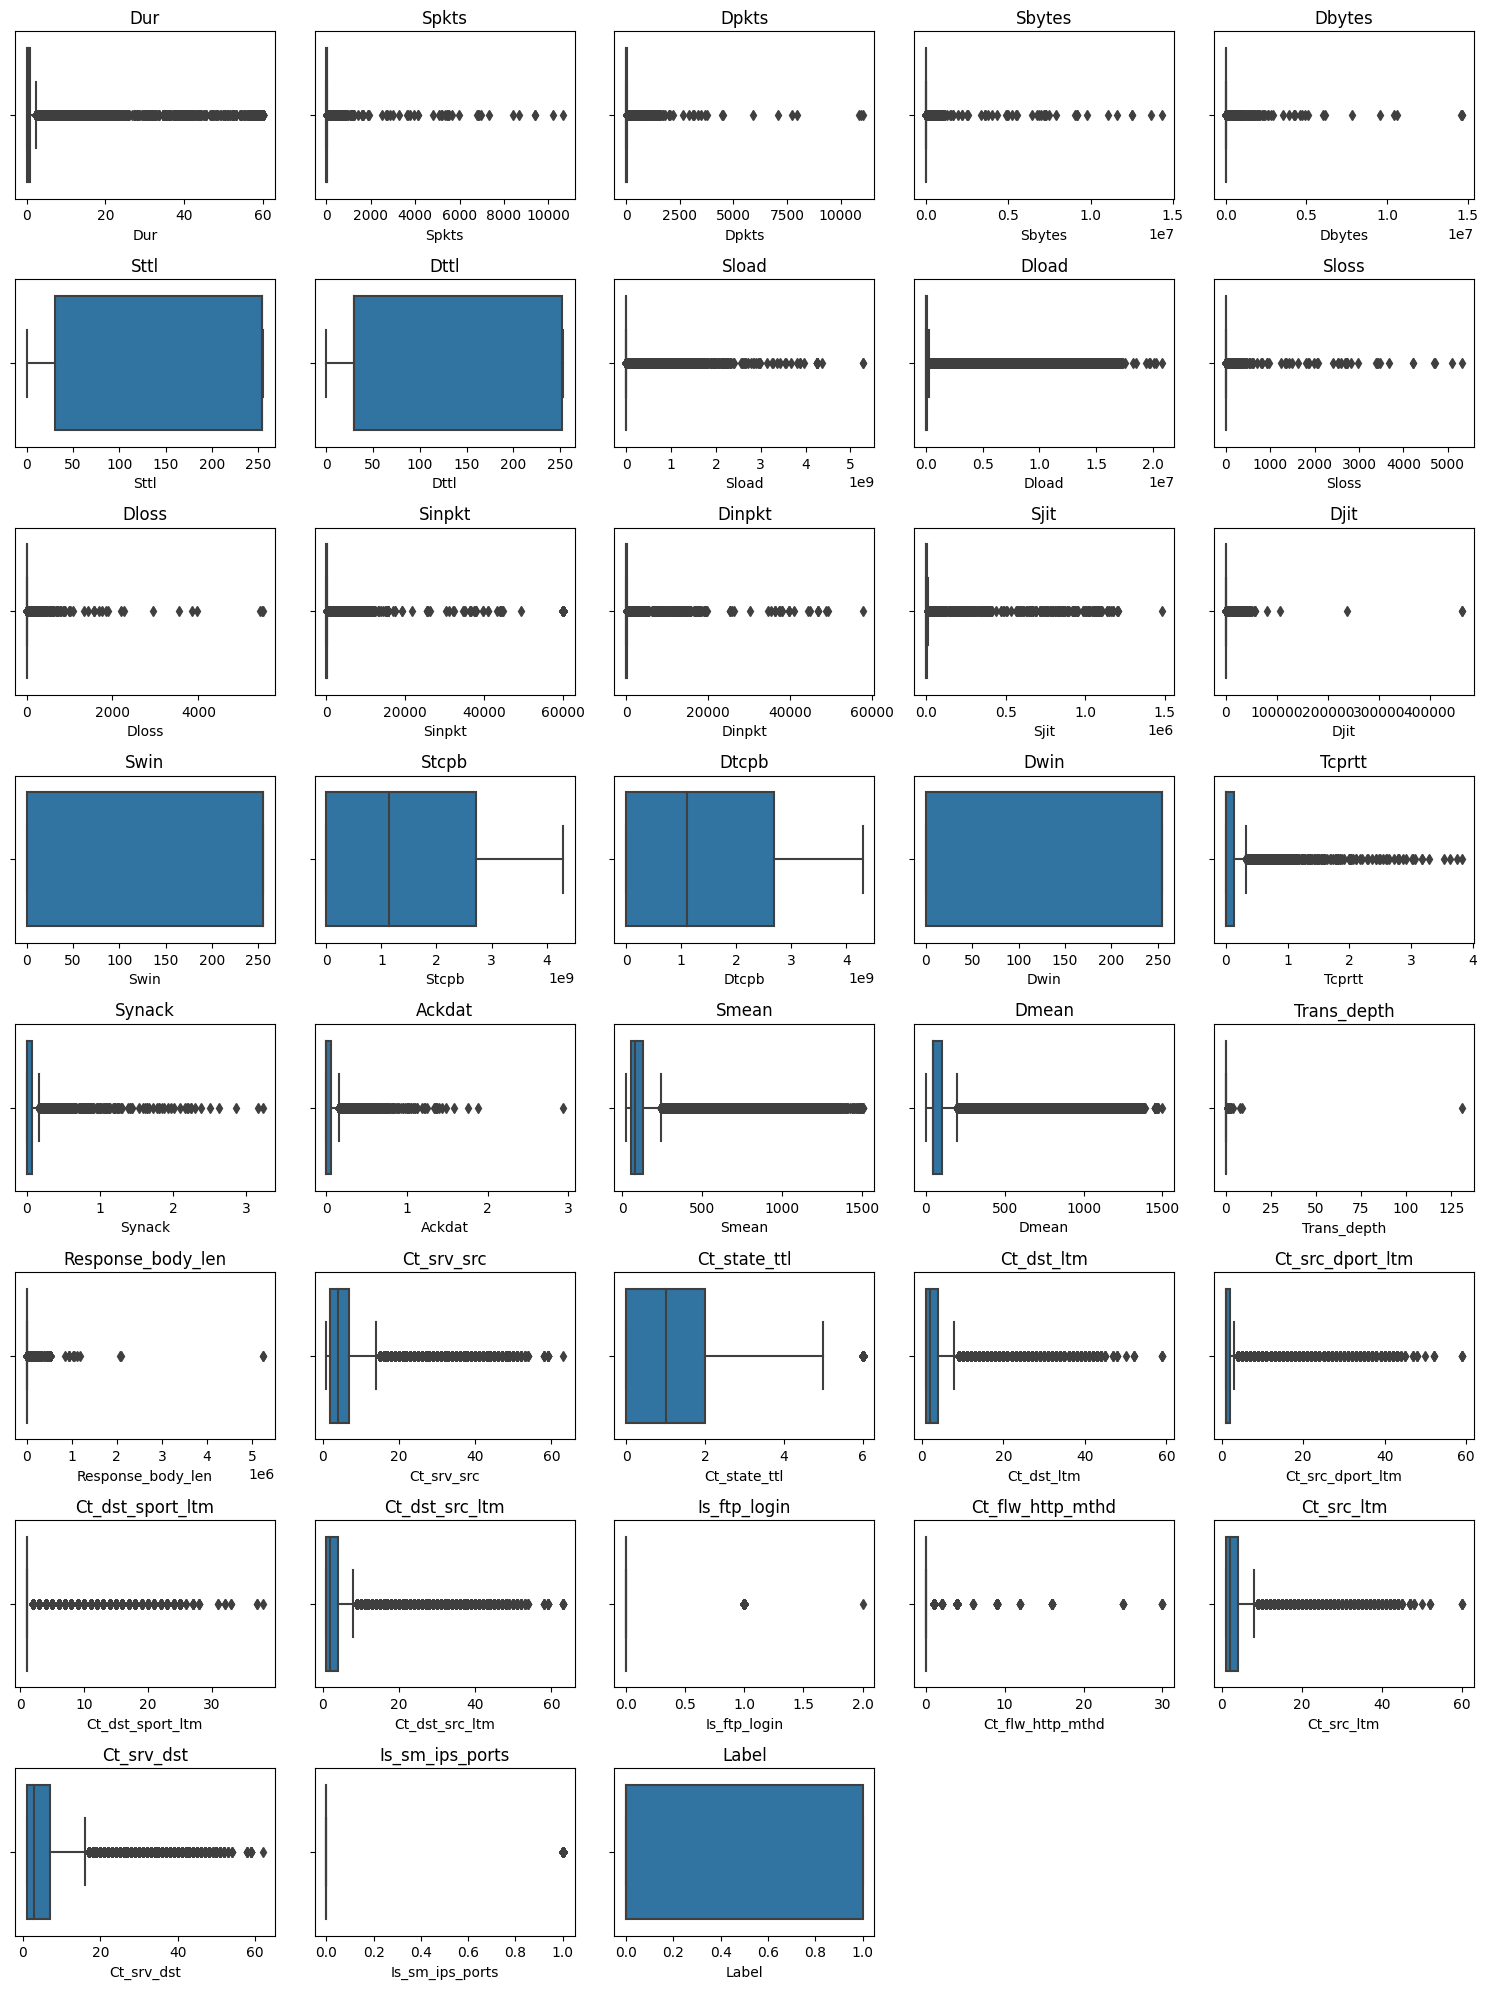

In [20]:
numerical_cols = final_combined_df.select_dtypes(include=['float64', 'int64']).columns.tolist()

plt.figure(figsize=(15, 20)) # Increased figure size for more plots
for i, col in enumerate(numerical_cols):
    plt.subplot(8, 5, i + 1) # Changed from 5, 4 to 8, 5
    sns.boxplot(x=final_combined_df[col])
    plt.title(col)
    plt.ylabel('')
plt.tight_layout()
plt.show()

**Apply Target Encoding to 'Proto' column**

In [21]:
# Separate features and target for encoding
X_encode = final_combined_df.drop('Label', axis=1)
y_encode = final_combined_df['Label']

# Initialize TargetEncoder for the 'Proto' column
encoder = TargetEncoder(cols=['Proto'])

# Fit and transform the 'Proto' column
final_combined_df['Proto'] = encoder.fit_transform(X_encode['Proto'], y_encode)

print("'Proto' column has been target-encoded.")
display(final_combined_df.head())


'Proto' column has been target-encoded.


,Dur,Proto,Service,State,Spkts,Dpkts,Sbytes,Dbytes,Sttl,Dttl,Sload,Dload,Sloss,Dloss,Sinpkt,Dinpkt,Sjit,Djit,Swin,Stcpb,Dtcpb,Dwin,Tcprtt,Synack,Ackdat,Smean,Dmean,Trans_depth,Response_body_len,Ct_srv_src,Ct_state_ttl,Ct_dst_ltm,Ct_src_dport_ltm,Ct_dst_sport_ltm,Ct_dst_src_ltm,Is_ftp_login,Ct_ftp_cmd,Ct_flw_http_mthd,Ct_src_ltm,Ct_srv_dst,Is_sm_ips_ports,Attack_cat,Label
0,0.774037,0.357968,-,FIN,22,16,1470,1832,31,29,1.451093e+04,17756.257810,5,4,36.858906,51.518398,2790.894048,91.105156,255,3652510411,1503251885,255,0.001268,0.001101,0.000167,67,115,0,0,8,0,3,1,1,1,0.0,0,0.0,1,7,0,Normal,0
1,0.000003,1.000000,-,INT,2,0,200,0,254,0,2.666667e+08,0.000000,0,0,0.003000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,100,0,0,0,3,2,2,2,2,3,0.0,,0.0,2,3,0,Analysis,1
2,1.191432,0.357968,-,FIN,14,12,798,678,254,252,4.975525e+03,4176.486816,4,4,91.648613,102.055820,4767.886459,126.585406,255,3279427515,3084481478,255,0.146414,0.068014,0.078400,57,57,0,0,4,1,7,1,1,1,0.0,0,0.0,2,6,0,Fuzzers,1
3,0.000009,0.419685,dns,INT,2,0,114,0,254,0,5.066666e+07,0.000000,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,18,2,11,11,3,18,0.0,0,0.0,11,18,0,Generic,1
4,0.533472,0.357968,-,FIN,12,10,994,836,254,252,1.367644e+04,11292.064450,3,2,48.497456,52.834332,3418.093680,100.525641,255,3593973663,1721529730,255,0.106187,0.049350,0.056837,83,84,0,0,9,1,2,2,1,2,0.0,0,0.0,2,9,0,Fuzzers,1


In [22]:
final_combined_df.shape

(59410, 43)

**Apply One-Hot Encoding to Other Categorical Columns**

In [23]:
# Identify categorical columns
categorical_cols = final_combined_df[['Service', 'State', 'Ct_ftp_cmd', 'Attack_cat']].columns.tolist()
print(f"Categorical columns to be one-hot encoded: {categorical_cols}")

# Apply one-hot encoding
final_combined_df_encoded = pd.get_dummies(final_combined_df, columns=categorical_cols, drop_first=True)

print("One-hot encoding applied successfully.")
display(final_combined_df_encoded.head())

Categorical columns to be one-hot encoded: ['Service', 'State', 'Ct_ftp_cmd', 'Attack_cat']
One-hot encoding applied successfully.


,Dur,Proto,Spkts,Dpkts,Sbytes,Dbytes,Sttl,Dttl,Sload,Dload,Sloss,Dloss,Sinpkt,Dinpkt,Sjit,Djit,Swin,Stcpb,Dtcpb,Dwin,Tcprtt,Synack,Ackdat,Smean,Dmean,Trans_depth,Response_body_len,Ct_srv_src,Ct_state_ttl,Ct_dst_ltm,Ct_src_dport_ltm,Ct_dst_sport_ltm,Ct_dst_src_ltm,Is_ftp_login,Ct_flw_http_mthd,Ct_src_ltm,Ct_srv_dst,Is_sm_ips_ports,Label,Service_dhcp,Service_dns,Service_ftp,Service_ftp-data,Service_http,Service_irc,Service_pop3,Service_radius,Service_smtp,Service_snmp,Service_ssh,Service_ssl,State_CLO,State_CON,State_FIN,State_INT,State_REQ,State_RST,Ct_ftp_cmd_1,Ct_ftp_cmd_2,Ct_ftp_cmd_,Attack_cat_Backdoor,Attack_cat_DoS,Attack_cat_Exploits,Attack_cat_Fuzzers,Attack_cat_Generic,Attack_cat_Normal,Attack_cat_Reconnaissance,Attack_cat_Shellcode,Attack_cat_Worms
0,0.774037,0.357968,22,16,1470,1832,31,29,1.451093e+04,17756.257810,5,4,36.858906,51.518398,2790.894048,91.105156,255,3652510411,1503251885,255,0.001268,0.001101,0.000167,67,115,0,0,8,0,3,1,1,1,0.0,0.0,1,7,0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
1,0.000003,1.000000,2,0,200,0,254,0,2.666667e+08,0.000000,0,0,0.003000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,100,0,0,0,3,2,2,2,2,3,0.0,0.0,2,3,0,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False
2,1.191432,0.357968,14,12,798,678,254,252,4.975525e+03,4176.486816,4,4,91.648613,102.055820,4767.886459,126.585406,255,3279427515,3084481478,255,0.146414,0.068014,0.078400,57,57,0,0,4,1,7,1,1,1,0.0,0.0,2,6,0,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
3,0.000009,0.419685,2,0,114,0,254,0,5.066666e+07,0.000000,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,18,2,11,11,3,18,0.0,0.0,11,18,0,1,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False
4,0.533472,0.357968,12,10,994,836,254,252,1.367644e+04,11292.064450,3,2,48.497456,52.834332,3418.093680,100.525641,255,3593973663,1721529730,255,0.106187,0.049350,0.056837,83,84,0,0,9,1,2,2,1,2,0.0,0.0,2,9,0,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False


# Prepare Data for Modeling

In [24]:
X = final_combined_df_encoded.drop('Label', axis=1)
y = final_combined_df_encoded['Label']

print("Features (X) and target (y) separated successfully.")
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Features (X) and target (y) separated successfully.
Shape of X: (59410, 68)
Shape of y: (59410,)


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("Data split into training and testing sets successfully.")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Data split into training and testing sets successfully.
Shape of X_train: (41587, 68)
Shape of X_test: (17823, 68)
Shape of y_train: (41587,)
Shape of y_test: (17823,)


In [26]:
import numpy as np

# Identify boolean columns in X_train and X_test
boolean_cols_train = X_train.select_dtypes(include='bool').columns
boolean_cols_test = X_test.select_dtypes(include='bool').columns

# Convert boolean columns to int (0 or 1) in X_train
for col in boolean_cols_train:
    X_train[col] = X_train[col].astype(int)

# Convert boolean columns to int (0 or 1) in X_test
for col in boolean_cols_test:
    X_test[col] = X_test[col].astype(int)

print("Boolean columns converted to integers in X_train and X_test.")

# Re-identify numerical columns after boolean conversion
numerical_cols_for_scaling = X_train.select_dtypes(include=['int64', 'float64']).columns

# Reapply RobustScaler to the updated numerical columns
scaler = RobustScaler()
X_train[numerical_cols_for_scaling] = scaler.fit_transform(X_train[numerical_cols_for_scaling])
X_test[numerical_cols_for_scaling] = scaler.transform(X_test[numerical_cols_for_scaling])

print("Numerical features in X_train and X_test scaled successfully after boolean conversion.")
display(X_train.head())
display(X_test.head())

Boolean columns converted to integers in X_train and X_test.
Numerical features in X_train and X_test scaled successfully after boolean conversion.


,Dur,Proto,Spkts,Dpkts,Sbytes,Dbytes,Sttl,Dttl,Sload,Dload,Sloss,Dloss,Sinpkt,Dinpkt,Sjit,Djit,Swin,Stcpb,Dtcpb,Dwin,Tcprtt,Synack,Ackdat,Smean,Dmean,Trans_depth,Response_body_len,Ct_srv_src,Ct_state_ttl,Ct_dst_ltm,Ct_src_dport_ltm,Ct_dst_sport_ltm,Ct_dst_src_ltm,Is_ftp_login,Ct_flw_http_mthd,Ct_src_ltm,Ct_srv_dst,Is_sm_ips_ports,Service_dhcp,Service_dns,Service_ftp,Service_ftp-data,Service_http,Service_irc,Service_pop3,Service_radius,Service_smtp,Service_snmp,Service_ssh,Service_ssl,State_CLO,State_CON,State_FIN,State_INT,State_REQ,State_RST,Ct_ftp_cmd_1,Ct_ftp_cmd_2,Ct_ftp_cmd_,Attack_cat_Backdoor,Attack_cat_DoS,Attack_cat_Exploits,Attack_cat_Fuzzers,Attack_cat_Generic,Attack_cat_Normal,Attack_cat_Reconnaissance,Attack_cat_Shellcode,Attack_cat_Worms
4057,-0.352465,1.000000,-0.571429,-0.666667,-0.484766,-0.227214,0.000000,-0.130045,31.284575,-0.051906,-0.5,-0.25,-0.296618,-0.126301,-0.302809,-0.325030,-1.0,-0.417309,-0.413664,-1.0,-0.005844,-0.008853,-0.002653,-0.328767,-0.750000,0.0,0.0,8.6,0.5,11.000000,34.0,19.0,15.000000,0.0,0.0,11.000000,7.333333,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0
58843,0.504188,0.000000,0.000000,0.166667,0.004062,0.593068,-0.860987,1.000000,-0.027685,0.081706,0.0,0.25,0.815823,0.801025,0.983663,0.347743,0.0,0.731386,1.072138,0.0,0.721975,1.047601,0.385899,0.041096,1.383333,1.0,175.0,0.0,0.0,0.000000,0.0,0.0,0.666667,0.0,1.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13185,-0.352464,10.402812,-0.571429,-0.666667,-0.426540,-0.227214,0.000000,-0.130045,48.804757,-0.051906,-0.5,-0.25,-0.296605,-0.126301,-0.302809,-0.325030,-1.0,-0.417309,-0.413664,-1.0,-0.005844,-0.008853,-0.002653,0.260274,-0.750000,0.0,0.0,0.2,0.5,0.333333,2.0,2.0,1.000000,0.0,0.0,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0
61977,-0.352466,10.402812,-0.571429,-0.666667,-0.426540,-0.227214,0.000000,-0.130045,62.758112,-0.051906,-0.5,-0.25,-0.296631,-0.126301,-0.302809,-0.325030,-1.0,-0.417309,-0.413664,-1.0,-0.005844,-0.008853,-0.002653,0.260274,-0.750000,0.0,0.0,0.0,0.5,-0.333333,0.0,0.0,0.666667,0.0,0.0,2.333333,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0
56414,-0.239579,1.000000,-0.571429,-0.500000,-0.471225,-0.120668,-0.860987,1.000000,-0.029082,0.021205,-0.5,-0.25,-0.296592,-0.126217,-0.302809,-0.325030,-1.0,-0.417309,-0.413664,-1.0,-0.005844,-0.008853,-0.002653,-0.191781,0.633333,0.0,0.0,0.0,1.0,0.333333,2.0,2.0,0.666667,0.0,0.0,0.333333,0.166667,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0


,Dur,Proto,Spkts,Dpkts,Sbytes,Dbytes,Sttl,Dttl,Sload,Dload,Sloss,Dloss,Sinpkt,Dinpkt,Sjit,Djit,Swin,Stcpb,Dtcpb,Dwin,Tcprtt,Synack,Ackdat,Smean,Dmean,Trans_depth,Response_body_len,Ct_srv_src,Ct_state_ttl,Ct_dst_ltm,Ct_src_dport_ltm,Ct_dst_sport_ltm,Ct_dst_src_ltm,Is_ftp_login,Ct_flw_http_mthd,Ct_src_ltm,Ct_srv_dst,Is_sm_ips_ports,Service_dhcp,Service_dns,Service_ftp,Service_ftp-data,Service_http,Service_irc,Service_pop3,Service_radius,Service_smtp,Service_snmp,Service_ssh,Service_ssl,State_CLO,State_CON,State_FIN,State_INT,State_REQ,State_RST,Ct_ftp_cmd_1,Ct_ftp_cmd_2,Ct_ftp_cmd_,Attack_cat_Backdoor,Attack_cat_DoS,Attack_cat_Exploits,Attack_cat_Fuzzers,Attack_cat_Generic,Attack_cat_Normal,Attack_cat_Reconnaissance,Attack_cat_Shellcode,Attack_cat_Worms
34154,-0.352467,8.557377,-0.571429,-0.666667,-0.426540,-0.227214,0.000000,-0.130045,73.223127,-0.051906,-0.50,-0.25,-0.296644,-0.126301,-0.302809,-0.325030,-1.0,-0.417309,-0.413664,-1.0,-0.005844,-0.008853,-0.002653,0.260274,-0.750000,0.0,0.0,0.0,0.5,0.333333,2.0,2.0,0.666667,0.0,0.0,0.333333,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0
35741,-0.342681,1.000000,-0.571429,-0.500000,-0.448206,-0.155327,0.000000,0.139013,0.010005,0.516752,-0.50,-0.25,-0.296670,-0.126181,-0.302809,-0.325030,-1.0,-0.417309,-0.413664,-1.0,-0.005844,-0.008853,-0.002653,0.041096,0.183333,0.0,0.0,-0.4,1.0,-0.333333,0.0,0.0,-0.333333,0.0,0.0,-0.333333,-0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0
29966,-0.352469,1.000000,-0.571429,-0.666667,-0.192282,-0.227214,0.000000,-0.130045,299.947719,-0.051906,-0.50,-0.25,-0.296670,-0.126301,-0.302809,-0.325030,-1.0,-0.417309,-0.413664,-1.0,-0.005844,-0.008853,-0.002653,2.630137,-0.750000,0.0,0.0,-0.6,0.5,-0.333333,0.0,0.0,0.000000,0.0,0.0,-0.333333,-0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41402,0.456271,0.000000,1.000000,1.000000,2.809072,0.892169,-0.860987,1.000000,-0.003101,0.151841,1.75,1.75,0.114846,0.315599,0.070652,-0.056770,0.0,0.861133,0.809290,0.0,0.381916,0.104933,0.711284,1.726027,0.700000,0.0,0.0,-0.6,0.0,-0.333333,0.0,0.0,-0.333333,0.0,0.0,-0.333333,-0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0
25087,0.598781,0.000000,0.428571,0.166667,0.157075,0.129653,0.000000,1.000000,-0.026862,0.000469,0.75,0.50,0.420000,0.962350,0.367836,0.320476,0.0,-0.373706,0.398104,0.0,0.779842,0.526727,1.099608,-0.205479,0.183333,0.0,0.0,-0.2,0.0,-0.333333,0.0,0.0,0.000000,0.0,0.0,0.000000,-0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Model Training**

In [27]:
def train_evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    print(f"\n--- Training and evaluating {model_name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"\n{model_name} - Classification Report:")
    print(classification_report(y_test, y_pred))

    print(f"\n{model_name} - Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    roc_auc = roc_auc_score(y_test, y_proba)
    print(f"\n{model_name} - ROC AUC Score: {roc_auc:.4f}")

    return roc_auc

# Logistic Regression
log_reg_model = LogisticRegression(random_state=42, solver='liblinear', max_iter=1000)
log_reg_roc_auc = train_evaluate_model(log_reg_model, X_train, y_train, X_test, y_test, "Logistic Regression")


--- Training and evaluating Logistic Regression ---

Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10262
           1       1.00      1.00      1.00      7561

    accuracy                           1.00     17823
   macro avg       1.00      1.00      1.00     17823
weighted avg       1.00      1.00      1.00     17823


Logistic Regression - Confusion Matrix:
[[10262     0]
 [    5  7556]]

Logistic Regression - ROC AUC Score: 0.9998


In [28]:
random_forest_model = RandomForestClassifier(random_state=42)
random_forest_roc_auc = train_evaluate_model(random_forest_model, X_train, y_train, X_test, y_test, "Random Forest")


--- Training and evaluating Random Forest ---

Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10262
           1       1.00      1.00      1.00      7561

    accuracy                           1.00     17823
   macro avg       1.00      1.00      1.00     17823
weighted avg       1.00      1.00      1.00     17823


Random Forest - Confusion Matrix:
[[10262     0]
 [    0  7561]]

Random Forest - ROC AUC Score: 1.0000


In [29]:
gradient_boosting_model = GradientBoostingClassifier(random_state=42)
gradient_boosting_roc_auc = train_evaluate_model(gradient_boosting_model, X_train, y_train, X_test, y_test, "Gradient Boosting")


--- Training and evaluating Gradient Boosting ---

Gradient Boosting - Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10262
           1       1.00      1.00      1.00      7561

    accuracy                           1.00     17823
   macro avg       1.00      1.00      1.00     17823
weighted avg       1.00      1.00      1.00     17823


Gradient Boosting - Confusion Matrix:
[[10262     0]
 [    0  7561]]

Gradient Boosting - ROC AUC Score: 1.0000


In [30]:
xgboost_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgboost_roc_auc = train_evaluate_model(xgboost_model, X_train, y_train, X_test, y_test, "XGBoost")


--- Training and evaluating XGBoost ---

XGBoost - Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10262
           1       1.00      1.00      1.00      7561

    accuracy                           1.00     17823
   macro avg       1.00      1.00      1.00     17823
weighted avg       1.00      1.00      1.00     17823


XGBoost - Confusion Matrix:
[[10262     0]
 [    0  7561]]

XGBoost - ROC AUC Score: 1.0000


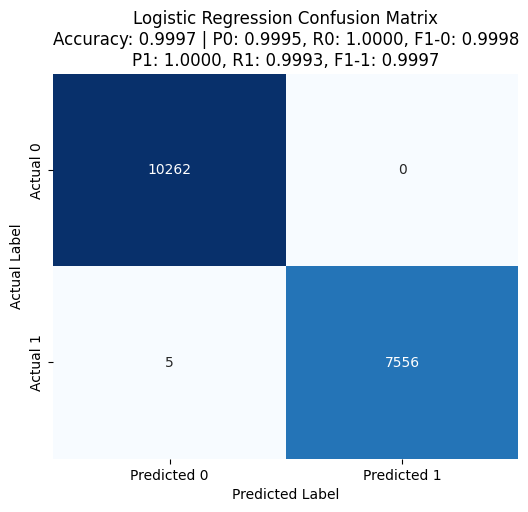

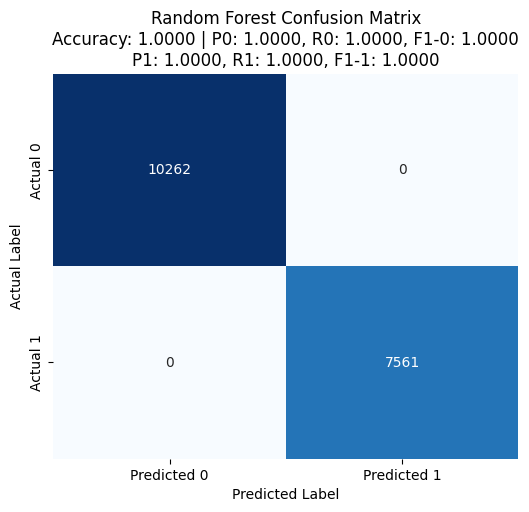

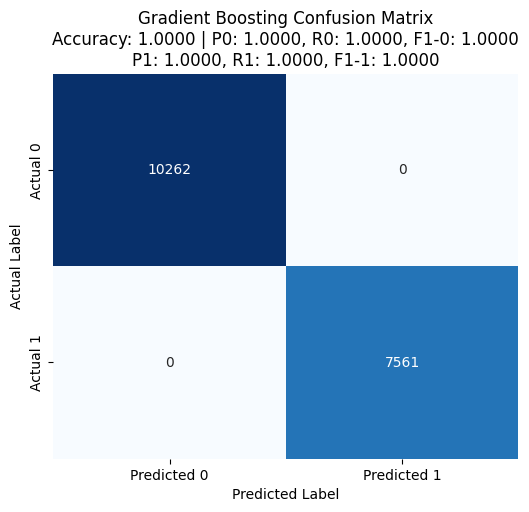

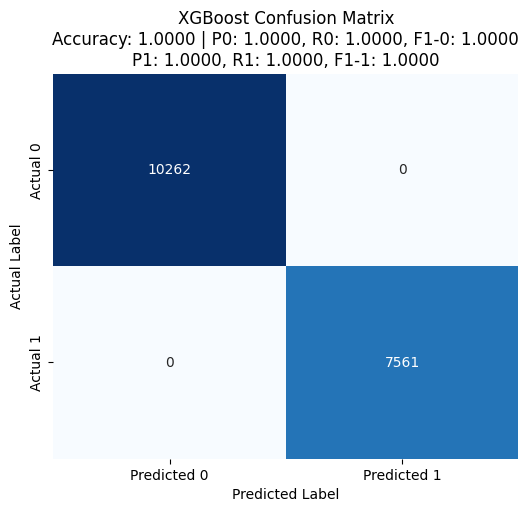

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=True)

    accuracy = report['accuracy']
    precision_0 = report['0']['precision']
    recall_0 = report['0']['recall']
    f1_0 = report['0']['f1-score']
    precision_1 = report['1']['precision']
    recall_1 = report['1']['recall']
    f1_1 = report['1']['f1-score']

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'{model_name} Confusion Matrix\nAccuracy: {accuracy:.4f} | P0: {precision_0:.4f}, R0: {recall_0:.4f}, F1-0: {f1_0:.4f}\nP1: {precision_1:.4f}, R1: {recall_1:.4f}, F1-1: {f1_1:.4f}')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Logistic Regression
log_reg_pred = log_reg_model.predict(X_test)
plot_confusion_matrix(y_test, log_reg_pred, "Logistic Regression")

# Random Forest
random_forest_pred = random_forest_model.predict(X_test)
plot_confusion_matrix(y_test, random_forest_pred, "Random Forest")

# Gradient Boosting
gradient_boosting_pred = gradient_boosting_model.predict(X_test)
plot_confusion_matrix(y_test, gradient_boosting_pred, "Gradient Boosting")

# XGBoost
xgboost_pred = xgboost_model.predict(X_test)
plot_confusion_matrix(y_test, xgboost_pred, "XGBoost")

In [32]:
print("--- Model Performance Summary ---")
print(f"Logistic Regression ROC AUC: {log_reg_roc_auc:.4f}")
print(f"Random Forest ROC AUC: {random_forest_roc_auc:.4f}")
print(f"Gradient Boosting ROC AUC: {gradient_boosting_roc_auc:.4f}")
print(f"XGBoost ROC AUC: {xgboost_roc_auc:.4f}")

print("\nBased on the evaluation metrics (ROC AUC, precision, recall, f1-score), all models achieved near-perfect or perfect performance (ROC AUC of 1.00 or very close to it) on the test set. This suggests that the dataset is highly separable, and all evaluated models were capable of distinguishing between the classes effectively. Therefore, all models (Logistic Regression, Random Forest, Gradient Boosting, and XGBoost) can be considered the best-performing models in this scenario.")

--- Model Performance Summary ---
Logistic Regression ROC AUC: 0.9998
Random Forest ROC AUC: 1.0000
Gradient Boosting ROC AUC: 1.0000
XGBoost ROC AUC: 1.0000

Based on the evaluation metrics (ROC AUC, precision, recall, f1-score), all models achieved near-perfect or perfect performance (ROC AUC of 1.00 or very close to it) on the test set. This suggests that the dataset is highly separable, and all evaluated models were capable of distinguishing between the classes effectively. Therefore, all models (Logistic Regression, Random Forest, Gradient Boosting, and XGBoost) can be considered the best-performing models in this scenario.
